### Stock Market Prediction And Forecasting Using Stacked LSTM

## Step 1 : Imports

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import tensorflow as tf

from sklearn.metrics import mean_squared_error
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

## Step 2 : Load Dataset

In [2]:
KEY = "e46970bde5460c8e6caece2452083771f7320e41"

In [3]:
df_master = pdr.get_data_tiingo('AAPL', api_key = KEY)
df_master.to_csv('AAPL.csv')
df_master=pd.read_csv('AAPL.csv')
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1257 entries, 0 to 1256
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   symbol       1257 non-null   object 
 1   date         1257 non-null   object 
 2   close        1257 non-null   float64
 3   high         1257 non-null   float64
 4   low          1257 non-null   float64
 5   open         1257 non-null   float64
 6   volume       1257 non-null   int64  
 7   adjClose     1257 non-null   float64
 8   adjHigh      1257 non-null   float64
 9   adjLow       1257 non-null   float64
 10  adjOpen      1257 non-null   float64
 11  adjVolume    1257 non-null   int64  
 12  divCash      1257 non-null   float64
 13  splitFactor  1257 non-null   float64
dtypes: float64(10), int64(2), object(2)
memory usage: 137.6+ KB


In [4]:
df_master.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2016-03-10 00:00:00+00:00,101.17,102.24,100.15,101.41,33513577,23.520683,23.769444,23.283547,23.576480,134054308,0.0,1.0
1,AAPL,2016-03-11 00:00:00+00:00,102.26,102.28,101.50,102.24,27408237,23.774094,23.778743,23.597404,23.769444,109632948,0.0,1.0
2,AAPL,2016-03-14 00:00:00+00:00,102.52,102.91,101.78,101.91,25076062,23.834540,23.925210,23.662500,23.692723,100304248,0.0,1.0
3,AAPL,2016-03-15 00:00:00+00:00,104.58,105.18,103.85,103.96,40067734,24.313463,24.452955,24.143748,24.169321,160270936,0.0,1.0
4,AAPL,2016-03-16 00:00:00+00:00,105.97,106.31,104.59,104.61,38303493,24.636619,24.715665,24.315788,24.320437,153213972,0.0,1.0


In [5]:
df_master.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1252,AAPL,2021-03-02 00:00:00+00:00,125.12,128.720,125.01,128.41,102260945,125.12,128.720,125.01,128.41,102260945,0.0,1.0
1253,AAPL,2021-03-03 00:00:00+00:00,122.06,125.710,121.84,124.81,112966340,122.06,125.710,121.84,124.81,112966340,0.0,1.0
1254,AAPL,2021-03-04 00:00:00+00:00,120.13,123.600,118.62,121.75,178154975,120.13,123.600,118.62,121.75,178154975,0.0,1.0
1255,AAPL,2021-03-05 00:00:00+00:00,121.42,121.935,117.57,120.98,153766601,121.42,121.935,117.57,120.98,153766601,0.0,1.0
1256,AAPL,2021-03-08 00:00:00+00:00,116.36,121.000,116.21,120.93,154376610,116.36,121.000,116.21,120.93,154376610,0.0,1.0


In [6]:
#df1 = df_master.reset_index()['close']

In [7]:
df = df_master[['date','close']].copy()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1257 entries, 0 to 1256
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1257 non-null   object 
 1   close   1257 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.8+ KB


In [9]:
df['date']= pd.to_datetime(df['date'])

In [10]:
df['date'].dt.strftime('%Y-%m-%d')

0       2016-03-10
1       2016-03-11
2       2016-03-14
3       2016-03-15
4       2016-03-16
           ...    
1252    2021-03-02
1253    2021-03-03
1254    2021-03-04
1255    2021-03-05
1256    2021-03-08
Name: date, Length: 1257, dtype: object

In [11]:
df.set_index('date', inplace = True)

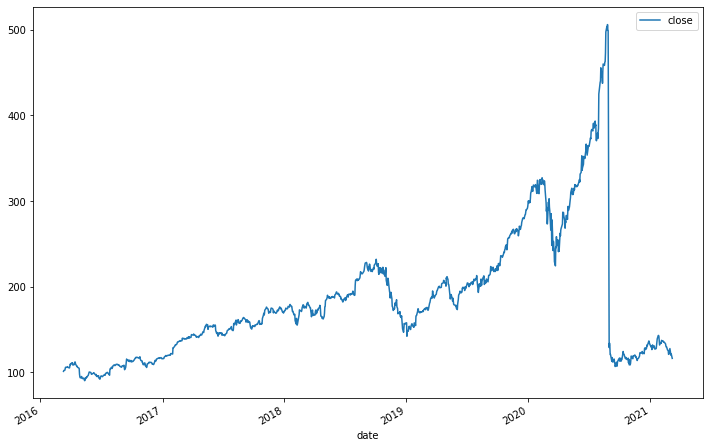

In [12]:
df.plot(figsize=(12,8))

## Step 3 : Train Test Split

In [13]:
len(df)

1257

In [14]:
test_size =  int(len(df)*0.35)
test_ind = len(df)- test_size

In [15]:
test_size

439

In [16]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [17]:
print(len(train))
print(len(test))

818
439


## Step 4 : Normalize

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

## Step 5 : Time Series Generator

In [19]:
# Please modify based on the problem : 
# Note n_inputs should be < size of test . 
# Here size of test = 439 so use 100
n_features = 1
n_input = 100
batch_size = 1

train_generator = TimeseriesGenerator(train, 
                                      train, 
                                      length = n_input, 
                                      batch_size = batch_size,
                                      shuffle = True)

# Shuffle is not needed b/c model will not see this data.
test_generator = TimeseriesGenerator(test, 
                                     test, 
                                     length = n_input, 
                                     batch_size = batch_size)

In [20]:
print(len(train_generator))
print(len(test_generator))

718
339


## Step 6 : Model

In [21]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape = (n_input,n_features)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [22]:
# from tensorflow.keras.callbacks import EarlyStopping
# early_stop = EarlyStopping(monitor ='val_loss', patience = 50)

In [23]:
history = model.fit(train_generator, epochs = 100 ,
                    validation_data = test_generator)

Epoch 1/100
718/718 [==============================] - 73s 56ms/step - loss: 0.0159 - val_loss: 0.1430
Epoch 2/100
718/718 [==============================] - 38s 54ms/step - loss: 0.0030 - val_loss: 0.0951
Epoch 3/100
718/718 [==============================] - 39s 54ms/step - loss: 0.0016 - val_loss: 0.0530
Epoch 4/100
718/718 [==============================] - 39s 54ms/step - loss: 0.0013 - val_loss: 0.0507
Epoch 5/100
718/718 [==============================] - 39s 54ms/step - loss: 0.0013 - val_loss: 0.0274
Epoch 6/100
718/718 [==============================] - 38s 54ms/step - loss: 0.0010 - val_loss: 0.0528
Epoch 7/100
718/718 [==============================] - 38s 54ms/step - loss: 9.5580e-04 - val_loss: 0.0298
Epoch 8/100
718/718 [==============================] - 39s 54ms/step - loss: 8.7043e-04 - val_loss: 0.0349
Epoch 9/100
718/718 [==============================] - 39s 54ms/step - loss: 8.8990e-04 - val_loss: 0.0403
Epoch 10/100
718/718 [==============================] - 39s 5

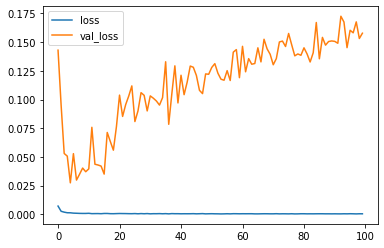

In [24]:
loss = pd.DataFrame(model.history.history)
loss.plot()

## Step 7 : Seed Data

In [25]:
batch = train[-n_input:].reshape((1, n_input, n_features))   # stepping stone value

## Step 8 : Prediction

In [26]:
pred_list = []
for i in range(n_input):   
    pred_list.append(model.predict(batch)[0])                # predict and save in list
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1) # next value for prediction

In [27]:
# We have done Predictions for these date times
df[-n_input:].index   # for the past 100 steps

DatetimeIndex(['2020-10-13 00:00:00+00:00', '2020-10-14 00:00:00+00:00',
               '2020-10-15 00:00:00+00:00', '2020-10-16 00:00:00+00:00',
               '2020-10-19 00:00:00+00:00', '2020-10-20 00:00:00+00:00',
               '2020-10-21 00:00:00+00:00', '2020-10-22 00:00:00+00:00',
               '2020-10-23 00:00:00+00:00', '2020-10-26 00:00:00+00:00',
               '2020-10-27 00:00:00+00:00', '2020-10-28 00:00:00+00:00',
               '2020-10-29 00:00:00+00:00', '2020-10-30 00:00:00+00:00',
               '2020-11-02 00:00:00+00:00', '2020-11-03 00:00:00+00:00',
               '2020-11-04 00:00:00+00:00', '2020-11-05 00:00:00+00:00',
               '2020-11-06 00:00:00+00:00', '2020-11-09 00:00:00+00:00',
               '2020-11-10 00:00:00+00:00', '2020-11-11 00:00:00+00:00',
               '2020-11-12 00:00:00+00:00', '2020-11-13 00:00:00+00:00',
               '2020-11-16 00:00:00+00:00', '2020-11-17 00:00:00+00:00',
               '2020-11-18 00:00:00+00:00', '2020-1

In [28]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=df[-n_input:].index, 
                          columns=['Prediction'])

In [29]:
df_predict

,Prediction
date,
2020-10-13 00:00:00+00:00,195.218377
2020-10-14 00:00:00+00:00,197.730590
2020-10-15 00:00:00+00:00,200.352997
2020-10-16 00:00:00+00:00,202.942744
2020-10-19 00:00:00+00:00,205.486155
...,...
2021-03-02 00:00:00+00:00,232.023182
2021-03-03 00:00:00+00:00,232.023157
2021-03-04 00:00:00+00:00,232.023140


## Step 9 : Prediction + Actual

In [30]:
df_test = pd.concat([df,df_predict], axis=1)

In [31]:
# Just to do sanity check that there is no prediction beyond our test window
df_test[-102:]

,close,Prediction
date,,
2020-10-09 00:00:00+00:00,116.97,NaN
2020-10-12 00:00:00+00:00,124.40,NaN
2020-10-13 00:00:00+00:00,121.10,195.218377
2020-10-14 00:00:00+00:00,121.19,197.730590
2020-10-15 00:00:00+00:00,120.71,200.352997
...,...,...
2021-03-02 00:00:00+00:00,125.12,232.023182
2021-03-03 00:00:00+00:00,122.06,232.023157
2021-03-04 00:00:00+00:00,120.13,232.023140


## Step 10 : Evaluation

In [34]:
from sklearn.metrics import max_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

test_errors = {}

test_errors ['MAX_Error'] = max_error(df_test.iloc[-n_input:, [0]], df_test.iloc[-n_input:, [1]])
test_errors ['MAE'] = mean_absolute_error(df_test.iloc[-n_input:, [0]], df_test.iloc[-n_input:, [1]])
test_errors ['RMSE'] = mean_squared_error(df_test.iloc[-n_input:, [0]], df_test.iloc[-n_input:, [1]], squared=False)
test_errors ['MSE'] = mean_squared_error(df_test.iloc[-n_input:, [0]], df_test.iloc[-n_input:, [1]], squared=True)

pd.Series(test_errors)


MAX_Error      117.616610
MAE            103.239031
RMSE           103.597879
MSE          10732.520567
dtype: float64

In [36]:
loss.tail(1)

,loss,val_loss
99,0.000461,0.157754


## Step 11 : Plot

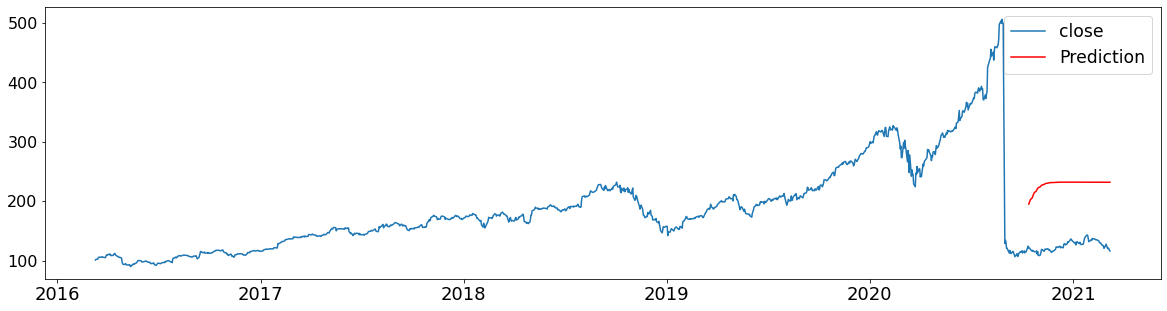

In [37]:
plt.figure(figsize=(20, 5))
plt.plot(df_test.index, df_test['close'])
plt.plot(df_test.index, df_test['Prediction'], color='r')
plt.legend(["close", "Prediction"], loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

## Step 12 : Future Forecasting

### Optional : 

In [ ]:
# optional if we want to re-train for the full dataset (no test train ds)
'''
train = df
len(train)
scaler.fit(train)
train = scaler.transform(train)

generator = TimeseriesGenerator(train, 
                                train, 
                                length = n_input, 
                                batch_size = n_batch_size)

model.fit(generator,epochs=100)
'''

### Prediction : 

In [38]:
future_days = 30   # 30 days

pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(future_days):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],
                      [[pred_list[i]]],
                      axis=1)

In [39]:
from pandas.tseries.offsets import DateOffset
add_dates = [df.index[-1] + DateOffset(days=x) for x in range(0, future_days + 1) ]
future_dates = pd.DataFrame(index = add_dates[1:],
                            columns = df.columns)

In [40]:
len(future_dates)

30

In [41]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=future_dates[-future_days:].index, 
                          columns=['Prediction'])

In [42]:
df_projected = pd.concat([df,df_predict], axis=1)

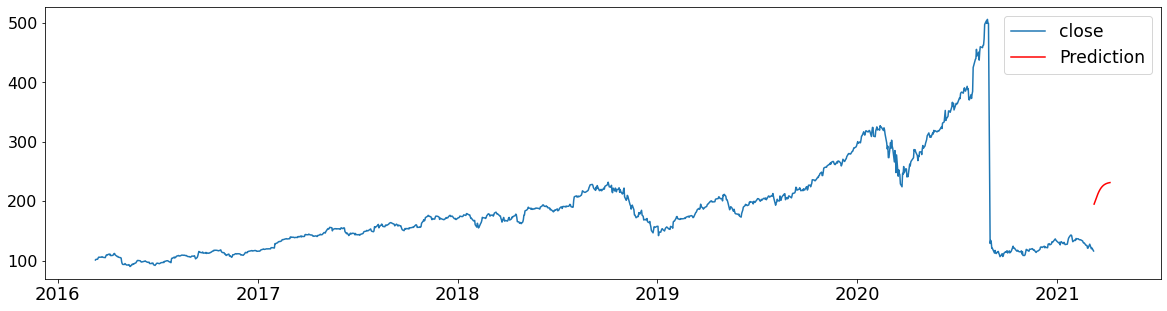

In [43]:
plt.figure(figsize=(20, 5))
plt.plot(df_projected.index, df_projected['close'])
plt.plot(df_projected.index, df_projected['Prediction'], color='r')
plt.legend(["close", "Prediction"], loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

## Conclusion : 